In [16]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from import_lib.func import sphere, weierstrass, ackley, rosenbrock, schwefel, griewank, rastrigin
from import_lib.GA import population_init, factorial_cost, factorial_rank, skill_factor_best_task, polynomial_mutation, sbx_crossover

In [17]:
'''
CEC'17
'''
tasks = [
    sphere(     50,shift= 0,    limited_space= True, lower_bound= -100, upper_bound= 100),   # 0
    sphere(     50,shift= 80,   limited_space= True, lower_bound= -100, upper_bound= 100),  # 80
    sphere(     50,shift= -80,  limited_space= True, lower_bound= -100, upper_bound= 100), # -80
    weierstrass(25,shift= -0.4, limited_space= True, lower_bound= -0.5, upper_bound= 0.5), # -0.4
    rosenbrock( 50,shift= -1,   limited_space= True, lower_bound= -50, upper_bound= 50),# 0
    ackley(     50,shift= 40,   limited_space= True, lower_bound= -50, upper_bound= 50),    # 40
    weierstrass(50,shift= -0.4, limited_space= True, lower_bound= -0.5, upper_bound= 0.5), # -0.4
    schwefel(   50,shift= 0,    limited_space= True, lower_bound= -500, upper_bound= 500), # 420.9687
    griewank(   50,shift= [-80, 80],limited_space= True, lower_bound= -100, upper_bound= 100), # -80, 80
    rastrigin(  50,shift= [-40, 40],limited_space= True, lower_bound= -50, upper_bound= 50),# -40, 40
]

In [18]:
print(tasks[0].func(tasks[0].encode(np.array([0] * 50))))
print(tasks[1].func(tasks[1].encode(np.array([80] * 50))))
print(tasks[2].func(tasks[2].encode(np.array([-80] * 50))))
print(tasks[3].func(tasks[3].encode(np.array([-0.4] * 50))))
print(tasks[4].func(tasks[4].encode(np.array([0] * 50))))
print(tasks[5].func(tasks[5].encode(np.array([40] * 50))))
print(tasks[6].func(tasks[6].encode(np.array([-0.4] * 50))))
print(tasks[7].func(tasks[7].encode(np.array([420.9687] * 50))))
print(tasks[8].func(tasks[8].encode(np.append(np.array([-80] * 25), np.array([80] * 25)))))
print(tasks[9].func(tasks[9].encode(np.append(np.array([-40] * 25), np.array([40] * 25)))))


0.0
0.0
0.0
0.0
0.0
4.440892098500626e-16
0.0
0.0006363918728311546
0.0
0.0


In [19]:
print(tasks[0].encode(np.array([0] * 50))[[0, -1]])
print(tasks[1].encode(np.array([80] * 50))[[0, -1]])
print(tasks[2].encode(np.array([-80] * 50))[[0, -1]])
print(tasks[3].encode(np.array([-0.4] * 25))[[0, -1]])
print(tasks[4].encode(np.array([0] * 50))[[0, -1]])
print(tasks[5].encode(np.array([40] * 50))[[0, -1]])
print(tasks[6].encode(np.array([-0.4] * 50))[[0, -1]])
print(tasks[7].encode(np.array([420.9687] * 50))[[0, -1]])
print(tasks[8].encode(np.append(np.array([-80] * 25), np.array([80] * 25)))[[0, -1]])
print(tasks[9].encode(np.append(np.array([-40] * 25), np.array([40] * 25)))[[0, -1]])

[0.5 0.5]
[0.1 0.1]
[0.9 0.9]
[0.9 0.9]
[0.52 0.52]
[0.1 0.1]
[0.9 0.9]
[0.9209687 0.9209687]
[0.9 0.1]
[0.9 0.1]


In [20]:
test_pop, test_ska = population_init(100, 3, 2)
print(test_pop.shape, test_ska.shape)

(300, 2) (300,)


In [21]:
sbx_crossover(np.array([0, 0, 0.3]), np.array([0.99, 1, 0.7]))

(array([0.        , 0.        , 0.27276326]),
 array([1.        , 1.        , 0.72723674]))

In [22]:
a = np.array([0, 1, 0.5], dtype= np.float)
print(polynomial_mutation(a, rm = 1, all_dimensions= False))


[0.01886332 0.99674188 0.53189621]


#### MFEA1

In [23]:
def MFEA_basic(num_epochs, num_inds_each_task, range_init_pop = [0, 1],tasks = [], rmp = 0.1, nc = 15, nm = 15, rm = 0.02,
                one_line = False, num_epochs_printed = 20, polynomial_all_gen = False):
    
    #save history of factorial cost
    history_cost = np.empty((0, len(tasks)), np.float)
    
    max_d = 0
    for t in tasks:
        if max_d < t.d:
            max_d = t.d

    # initial population and skill_factor_arr
    inf, sup = range_init_pop
    population, skill_factor_arr = population_init(
        N = num_inds_each_task, 
        num_tasks = len(tasks), 
        d = max_d,
        min_val = inf,
        max_val = sup,
    )

    skill_factor_arr = skill_factor_best_task(population, tasks)
    pop_fcost = factorial_cost(population, skill_factor_arr, tasks)

    history_cost = np.append(history_cost, [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], axis = 0)
    
    for epoch in range(num_epochs):

        #initial offspring for epoch
        offspring = np.empty((0, max_d))
        offspring_skill_factor = np.empty((0, 1), np.int)
        offspring_fcost = np.empty((0, 1))

        while len(offspring) < len(population):
            [idx_a, idx_b] = np.random.randint(len(population), size = 2)
            [pa, pb], [skf_a, skf_b] = population[[idx_a, idx_b]], skill_factor_arr[[idx_a, idx_b]]

            if skf_a == skf_b:
                # intra - crossover
                ca, cb = sbx_crossover(pa, pb, nc)
                            
                ca = polynomial_mutation(ca,nm, rm, polynomial_all_gen)
                cb = polynomial_mutation(cb,nm, rm, polynomial_all_gen)   
                
                offspring = np.append(offspring, [ca, cb], axis = 0)
                offspring_skill_factor = np.append(offspring_skill_factor, [skf_a, skf_a])

            elif np.random.uniform() <= rmp:
                # inter - crossover
                ca, cb = sbx_crossover(pa, pb, nc)
                            
                ca = polynomial_mutation(ca,nm, rm, polynomial_all_gen)
                cb = polynomial_mutation(cb,nm, rm, polynomial_all_gen)   

                offspring = np.append(offspring, [ca, cb], axis = 0)
                skf_ca, skf_cb = np.random.choice([skf_a, skf_b], 2, True)
                offspring_skill_factor = np.append(offspring_skill_factor, [skf_ca, skf_cb])
   
            else:
                # select pa' and pb'
                idx_pa2 = np.random.choice(np.where(skill_factor_arr == skf_a)[0])
                idx_pb2 = np.random.choice(np.where(skill_factor_arr == skf_b)[0])
                pa2 = population[idx_pa2]
                pb2 = population[idx_pb2]

                ca, _ = sbx_crossover(pa, pa2)
                cb, _ = sbx_crossover(pb, pb2)
                            
                ca = polynomial_mutation(ca,nm, rm, polynomial_all_gen)
                cb = polynomial_mutation(cb,nm, rm, polynomial_all_gen)   
            
                offspring = np.append(offspring, [ca, cb], axis = 0)
                offspring_skill_factor = np.append(offspring_skill_factor, [skf_a, skf_b])   
    
        # merge
        offspring_fcost = factorial_cost(offspring, offspring_skill_factor, tasks)

        population = np.append(population, offspring, axis = 0)
        skill_factor_arr = np.append(skill_factor_arr, offspring_skill_factor, axis = 0)
        pop_fcost = np.append(pop_fcost, offspring_fcost, axis = 0)

        # selection
        pop_finess = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))
        num_inds_pop = np.int(num_inds_each_task)* len(tasks)
        selected_inds = np.argsort(-pop_finess)[:num_inds_pop] 
        population, skill_factor_arr = population[selected_inds], skill_factor_arr[selected_inds]
        pop_fcost = pop_fcost[selected_inds]

        #save history
        history_cost = np.append(history_cost, [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], axis = 0)

        #print
        if (epoch + 1) % (num_epochs // num_epochs_printed) == 0:
            if one_line == True:
                sys.stdout.write('\r')
            sys.stdout.write('Epoch [{}/{}], [%-20s] %3d%% ,func_val: {}'
                .format(epoch + 1, num_epochs,[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))])
                % ('=' * ((epoch + 1) // (num_epochs // 20)) + '>' , (epoch + 1) * 100 // num_epochs)
                )
            if one_line == False:
                print("\n")
            sys.stdout.flush()
    print('END!')
    #find solve
    sol_idx = [np.argmin(pop_fcost[np.where(skill_factor_arr == idx)]) for idx in range (len(tasks))]
    sol = [task.decode(population[np.where(skill_factor_arr == idx)][sol_idx[idx]]) for idx, task in enumerate(tasks)]

    return sol, history_cost

In [24]:
mfea_sol, mfea_his = MFEA_basic(num_epochs= 1000, num_inds_each_task= 100, 
                        tasks = tasks, rmp = 0.3, nc = 2, nm = 5, rm = 0.02,
                        one_line=False, num_epochs_printed=10, polynomial_all_gen= False)

np.save(file = "./RESULTS/mfea_base_his_CEC17.npy", arr = mfea_his )

Epoch [100/1000], [==>                 ]  10% ,func_val: [1322.7435579027897, 4678.87859117443, 5971.830585383829, 7.171896115010618, 452306.77855852764, 9.485120706514923, 30.56409096702437, 2302.9066339503333, 4.8560555711275954, 4022.3755113395573]

Epoch [200/1000], [====>               ]  20% ,func_val: [353.2732368720855, 78.66021730783473, 423.0371897707848, 3.7599732153702234, 54775.352584489956, 4.017371835974075, 13.299189058573774, 1101.3733579272448, 1.4035425532261476, 762.0486520326865]

Epoch [300/1000], [======>             ]  30% ,func_val: [183.09658402725412, 18.673940278369663, 128.94822406149333, 2.662252349147437, 16492.512801411147, 2.7048917933658534, 9.94322180179546, 809.5238756750114, 1.1042441734696253, 418.605021817281]

Epoch [400/1000], [========>           ]  40% ,func_val: [91.26710264047935, 9.876798950185124, 39.85550645276888, 2.112905498781835, 5314.55597325911, 2.0515408736194485, 7.248964378094257, 495.57941541015316, 1.0243627183352069, 243.01427

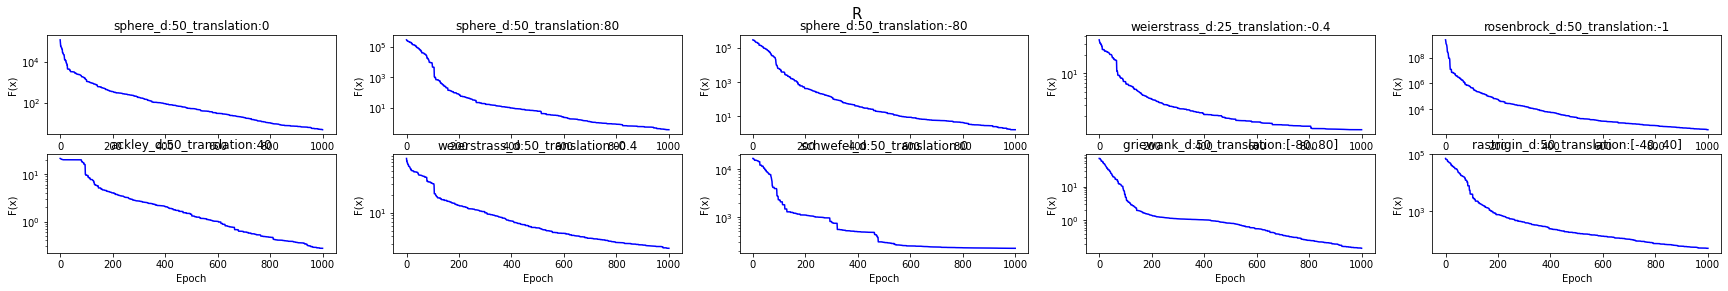

In [25]:
fig = plt.figure(figsize = (30, 4))
fig.suptitle("R\n", size = 15)
fig.set_facecolor("white")

for i in range (mfea_his.shape[1]):
    plt.subplot(2, int(len(tasks)/2), i + 1)

    plt.plot(np.arange(len(mfea_his)), mfea_his[:, i], "blue")
    plt.title(tasks[i].name)
    plt.xlabel("Epoch")
    plt.ylabel("F(x)")
    plt.yscale('log')



#### MFEA: SA AND LSA

In [26]:
def Success_History_Memory_Update(M, next_update_position_M, S, delta, K):

    for i in range(K):
        for j in range(i + 1, K):
            if len(S[i][j]) != 0:
                M[i, j][next_update_position_M[i, j]] =\
                    np.sum(np.array(delta[i][j]) * np.array(S[i][j])**2)/np.sum(np.array(delta[i][j]) * (np.array(S[i][j]))+ 1e-10)
                
                next_update_position_M[i, j] = (next_update_position_M[i, j] + 1) % M.shape[2]

    return M, next_update_position_M

In [27]:
def LSA_MFEA(MAXEVALS, num_inds_each_task, N_min = 50, tasks = [], nc = 2, nm = 5, rm = 0.05, H = 30, sigmoid = 0.1, 
            LSA = True, polynomial_all_gen = False):

    #save history of factorial cost
    history_cost = np.empty((0, len(tasks)), np.float)
    
    max_d = 0
    for t in tasks:
        if max_d < t.d:
            max_d = t.d

    N_max = num_inds_each_task
    maxEvals = MAXEVALS/len(tasks)
    eval_k = [0]*len(tasks)
    epoch = 0

    # initial population and skill_factor_arr
    population, skill_factor_arr = population_init(
        N = num_inds_each_task, 
        num_tasks = len(tasks), 
        d = max_d,
        min_val = 0,
        max_val = 1,
    )

    # get skill_factor for pop
    skill_factor_arr = skill_factor_best_task(population, tasks)
    population_factorial_cost = factorial_cost(population, skill_factor_arr, tasks)

    history_cost = np.append(history_cost, [[np.min(population_factorial_cost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], axis = 0)

    #Inittialize success history mem M
    M = np.ones((len(tasks), len(tasks), H)) / 2
    next_update_position_M = np.zeros((len(tasks), len(tasks)), dtype= np.int)

    # mean and sd of rmp each generations
    # len(task) * len(tasks) * generations * 2
    saved_rmp = np.array([[[[0.5, 0]]]* len(tasks)] * len(tasks)).tolist()

    while np.sum(eval_k) < MAXEVALS:

        S = np.empty((len(tasks), len(tasks), 0)).tolist()
        delta = np.empty((len(tasks), len(tasks), 0)).tolist()

        #initial offspring for epoch
        offspring = np.empty((0, max_d))
        offspring_skill_factor = np.empty((0, ), np.int)
        offspring_factorial_cost = np.empty((0, ), np.int)

        # his rmp of this generation
        rmp_this_gen = np.empty((len(tasks), len(tasks), 0)).tolist()

        while len(offspring_skill_factor) < len(population):
            #random 2 inds
            [idx_pa, idx_pb] = np.random.randint(len(population), size = 2)
            [pa, pb], [skf_pa, skf_pb] = population[[idx_pa, idx_pb]], skill_factor_arr[[idx_pa, idx_pb]]    

            if skf_pa == skf_pb:
                oa, ob = sbx_crossover(pa, pb, nc)

                oa = polynomial_mutation(oa,nm, rm, polynomial_all_gen)
                ob = polynomial_mutation(ob,nm, rm, polynomial_all_gen)
                
                skf_oa, skf_ob = skf_pa, skf_pa

                # Evaluate oa, ob
                fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)
                eval_k[skf_oa] += 1
                eval_k[skf_ob] += 1
            else:
                #swap
                if skf_pa > skf_pb: 
                    pa, pb = pb, pa
                    skf_pa, skf_pb = skf_pb, skf_pa

                # caculate rmp
                mu = np.random.choice(M[skf_pa, skf_pb])
                rmp = np.random.normal(mu, sigmoid)
                if rmp < 0: rmp = 0
                if rmp > 1: rmp = 1

                # save generation's rmp
                rmp_this_gen[skf_pa][skf_pb].append(rmp)

                # Inter-task crossover
                if np.random.uniform() < rmp:
                    oa, ob = sbx_crossover(pa, pb, nc)

                    oa = polynomial_mutation(oa,nm,rm, polynomial_all_gen)
                    ob = polynomial_mutation(ob,nm,rm, polynomial_all_gen)
                    
                    skf_oa, skf_ob = np.random.choice([skf_pa, skf_pb], replace=True, size = 2)
                else:
                    # select pa' and pb'
                    idx_pa2 = np.random.choice(np.where(skill_factor_arr == skf_pa)[0])
                    idx_pb2 = np.random.choice(np.where(skill_factor_arr == skf_pb)[0])
                    pa2 = population[idx_pa2]
                    pb2 = population[idx_pb2]

                    oa, _ = sbx_crossover(pa, pa2)
                    ob, _ = sbx_crossover(pb, pb2)

                    oa = polynomial_mutation(oa,nm,rm, polynomial_all_gen)
                    ob = polynomial_mutation(ob,nm,rm, polynomial_all_gen)

                    skf_oa, skf_ob = skf_pa, skf_pb
                
                # Evaluate oa, ob
                fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)
                eval_k[skf_oa] += 1
                eval_k[skf_ob] += 1

                # Caculate the maximum imporvement percentage
                Delta = 0
                if (skf_oa == skf_pa):
                    Delta = max(Delta, 
                        (population_factorial_cost[idx_pa] - fcost_oa)/population_factorial_cost[idx_pa]
                    )
                else:
                    Delta = max(Delta, 
                        (population_factorial_cost[idx_pb] - fcost_oa)/population_factorial_cost[idx_pb]
                    )
                if (skf_ob == skf_pa):
                    Delta = max(Delta, 
                        (population_factorial_cost[idx_pa] - fcost_ob)/population_factorial_cost[idx_pa]
                    )
                else:
                    Delta = max(Delta, 
                        (population_factorial_cost[idx_pb] - fcost_ob)/population_factorial_cost[idx_pb]
                    )

                if Delta > 0:
                    S[skf_pa][skf_pb].append(rmp)
                    delta[skf_pa][skf_pb].append(Delta)

            offspring = np.append(offspring, [oa, ob], axis = 0)
            offspring_skill_factor = np.append(offspring_skill_factor, [skf_oa, skf_ob])
            offspring_factorial_cost = np.append(offspring_factorial_cost, [fcost_oa, fcost_ob])
        
        M, next_update_position_M = Success_History_Memory_Update(M, next_update_position_M, S, delta, K = len(tasks))

        # update pop
        population = np.append(population, offspring, axis = 0)
        skill_factor_arr = np.append(skill_factor_arr, offspring_skill_factor, axis = 0)
        population_factorial_cost = np.append(population_factorial_cost, offspring_factorial_cost, axis = 0)

        # Linear_Population_Size_Reduction_Strategy 
        idx_selected_inds = np.empty((0,),dtype=int)
        scalar_fitness = 1/factorial_rank(population_factorial_cost, skill_factor_arr, len(tasks))
        for i in range(len(tasks)): 
            if LSA :
                N_i = int(min(N_max - eval_k[i]/maxEvals * (N_max - N_min), len(np.where(skill_factor_arr == i)[0])))
            else:
                N_i = num_inds_each_task
            ind_task_i = np.where(skill_factor_arr == i)[0]
            sort_idx = ind_task_i[np.argsort(- scalar_fitness[ind_task_i])]
            idx_selected_inds = np.append(idx_selected_inds, sort_idx[:N_i], axis = 0)
        
        population = population[idx_selected_inds]
        skill_factor_arr = skill_factor_arr[idx_selected_inds]
        population_factorial_cost = population_factorial_cost[idx_selected_inds]

        #save history
        history_cost = np.append(history_cost, [[np.min(population_factorial_cost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], axis = 0)
        
        #save mu and sigmoid rmp
        for i in range (len(tasks)):
            for j in range (i + 1, len(tasks)):
                if len(rmp_this_gen[i][j]) != 0:
                    mu = np.mean(rmp_this_gen[i][j])
                    sd = np.std(rmp_this_gen[i][j])
                    saved_rmp[i][j].append([mu, sd])

        #print
        sys.stdout.write('\r')
        sys.stdout.write('Epoch {}, [%-20s] %3d%% ,pop_size: {}, func_val: {}'
            .format(epoch + 1, len(population),[np.min(population_factorial_cost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))])
            % ('=' * ((np.sum(eval_k) + 1) // (MAXEVALS // 20)) + '>' , (np.sum(eval_k) + 1) * 100 // MAXEVALS)
            )
        sys.stdout.flush()

        epoch += 1

    #find solve
    sol_idx = [np.argmin(population_factorial_cost[np.where(skill_factor_arr == idx)]) for idx in range (len(tasks))]
    sol = [task.decode(population[np.where(skill_factor_arr == idx)][sol_idx[idx]]) for idx, task in enumerate(tasks)]

    return sol, history_cost, np.array(saved_rmp)

In [28]:
sa_sol, sa_his, sa_rmp_his = LSA_MFEA(100000 * len(tasks), LSA = False, num_inds_each_task= 100, tasks= tasks,
                                    nc = 2, nm = 5, H = 30, sigmoid= 0.1, rm = 0.02)

np.save(file = "./RESULTS/sa_his_CEC17.npy", arr = sa_his)
np.save(file = "./RESULTS/sa_rmp_his_CEC17.npy", arr = sa_rmp_his )

Epoch 1000, [====================>] 100% ,pop_size: 1000, func_val: [12.640974907804154, 1.1080694598808345, 2.241183502687975, 0.40537319623803114, 443.111923438674, 0.5946468279090635, 3.082553475443092, 350.6656529783904, 0.14104413833295748, 70.96036977216619]

/tmp/ipykernel_41613/1841161540.py:188: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return sol, history_cost, np.array(saved_rmp)


In [29]:
lsa_sol, lsa_his, lsa_rmp_his = LSA_MFEA(80000 * len(tasks), num_inds_each_task= 100, tasks= tasks, 
                                        nc = 2, nm = 5, H = 30, sigmoid= 0.1, rm = 0.02)
np.save(file = "./RESULTS/lsa_his_CEC17.npy", arr = lsa_his)
np.save(file = "./RESULTS/lsa_rmp_his_CEC17.npy", arr = lsa_rmp_his )

Epoch 1117, [====================>] 100% ,pop_size: 495, func_val: [8.569812699018588, 1.7477363439006244, 1.986852264688849, 0.5470001421012967, 391.04809874056946, 0.7625875429563149, 2.761498903615262, 5.645571672113874, 0.13018684673513492, 55.813410294900336]

/tmp/ipykernel_41613/1841161540.py:188: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return sol, history_cost, np.array(saved_rmp)


In [30]:
mfea_his = np.load(file = "./RESULTS/mfea_base_his_CEC17.npy")

sa_his = np.load(file = "./RESULTS/sa_his_CEC17.npy")
sa_rmp_his  = np.load(file = "./RESULTS/sa_rmp_his_CEC17.npy", allow_pickle= True)

lsa_his = np.load(file = "./RESULTS/lsa_his_CEC17.npy")
lsa_rmp_his  = np.load(file = "./RESULTS/lsa_rmp_his_CEC17.npy", allow_pickle= True)

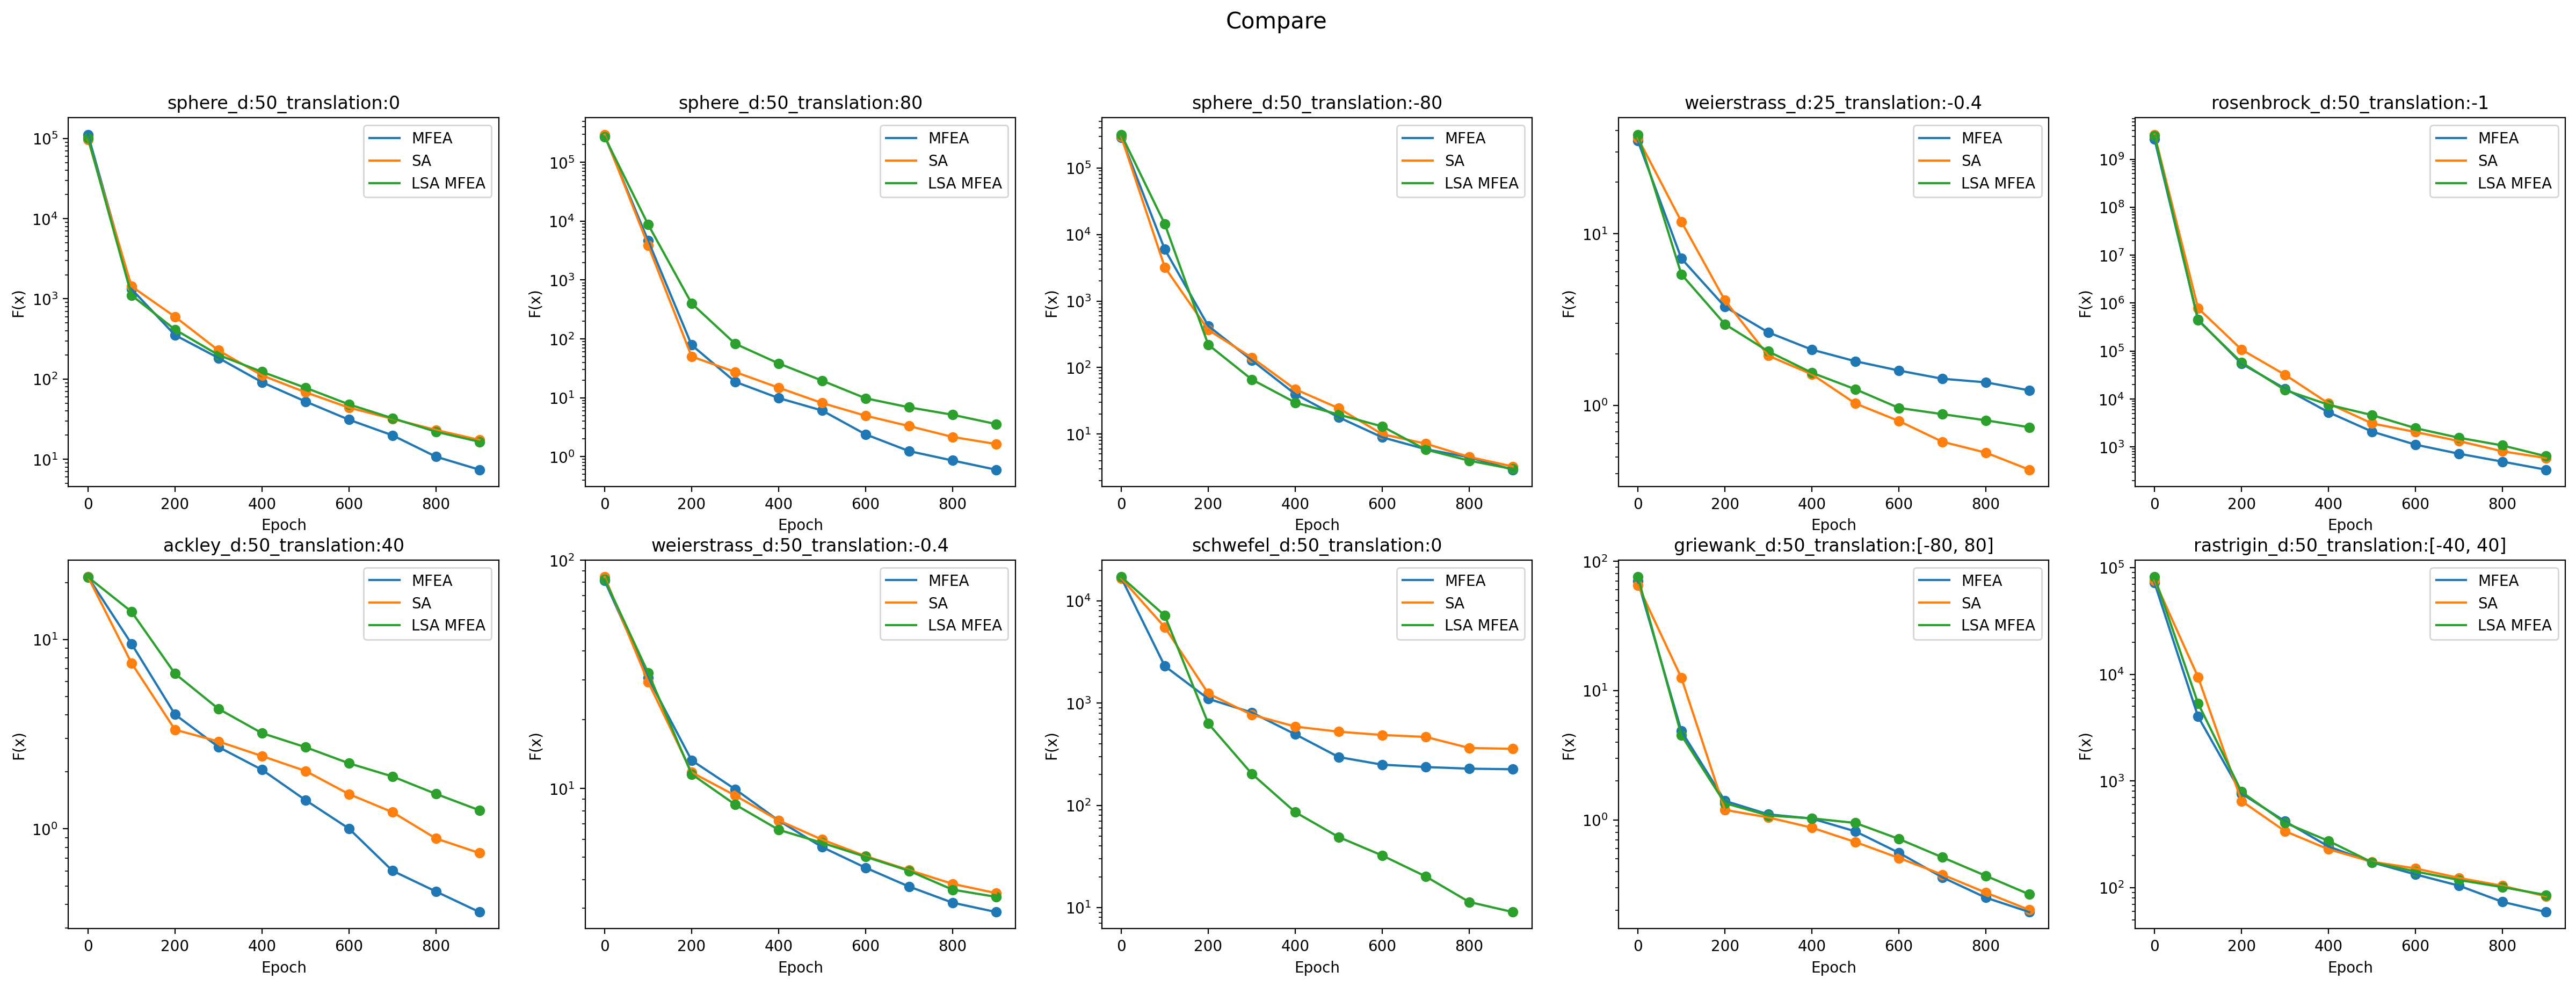

In [31]:
fig = plt.figure(figsize = (30, 10), dpi= 200)
fig.suptitle("Compare\n", size = 15)
fig.set_facecolor("white")

label_legend = ["MFEA", "SA", "LSA MFEA"]

for i in range (len(tasks)):
    for idx, sub_his in enumerate([mfea_his, sa_his, lsa_his]): 
        plt.subplot(2, int(len(tasks) / 2), i + 1)

        plt.plot(np.arange(0, 1000, 100), sub_his[np.arange(0, 1000, 100), i], label= label_legend[idx])
        plt.scatter(np.arange(0, 1000, 100), sub_his[np.arange(0, 1000, 100), i])
        plt.legend()

    plt.title(tasks[i].name)
    plt.xlabel("Epoch")
    plt.ylabel("F(x)")
    plt.yscale("log")

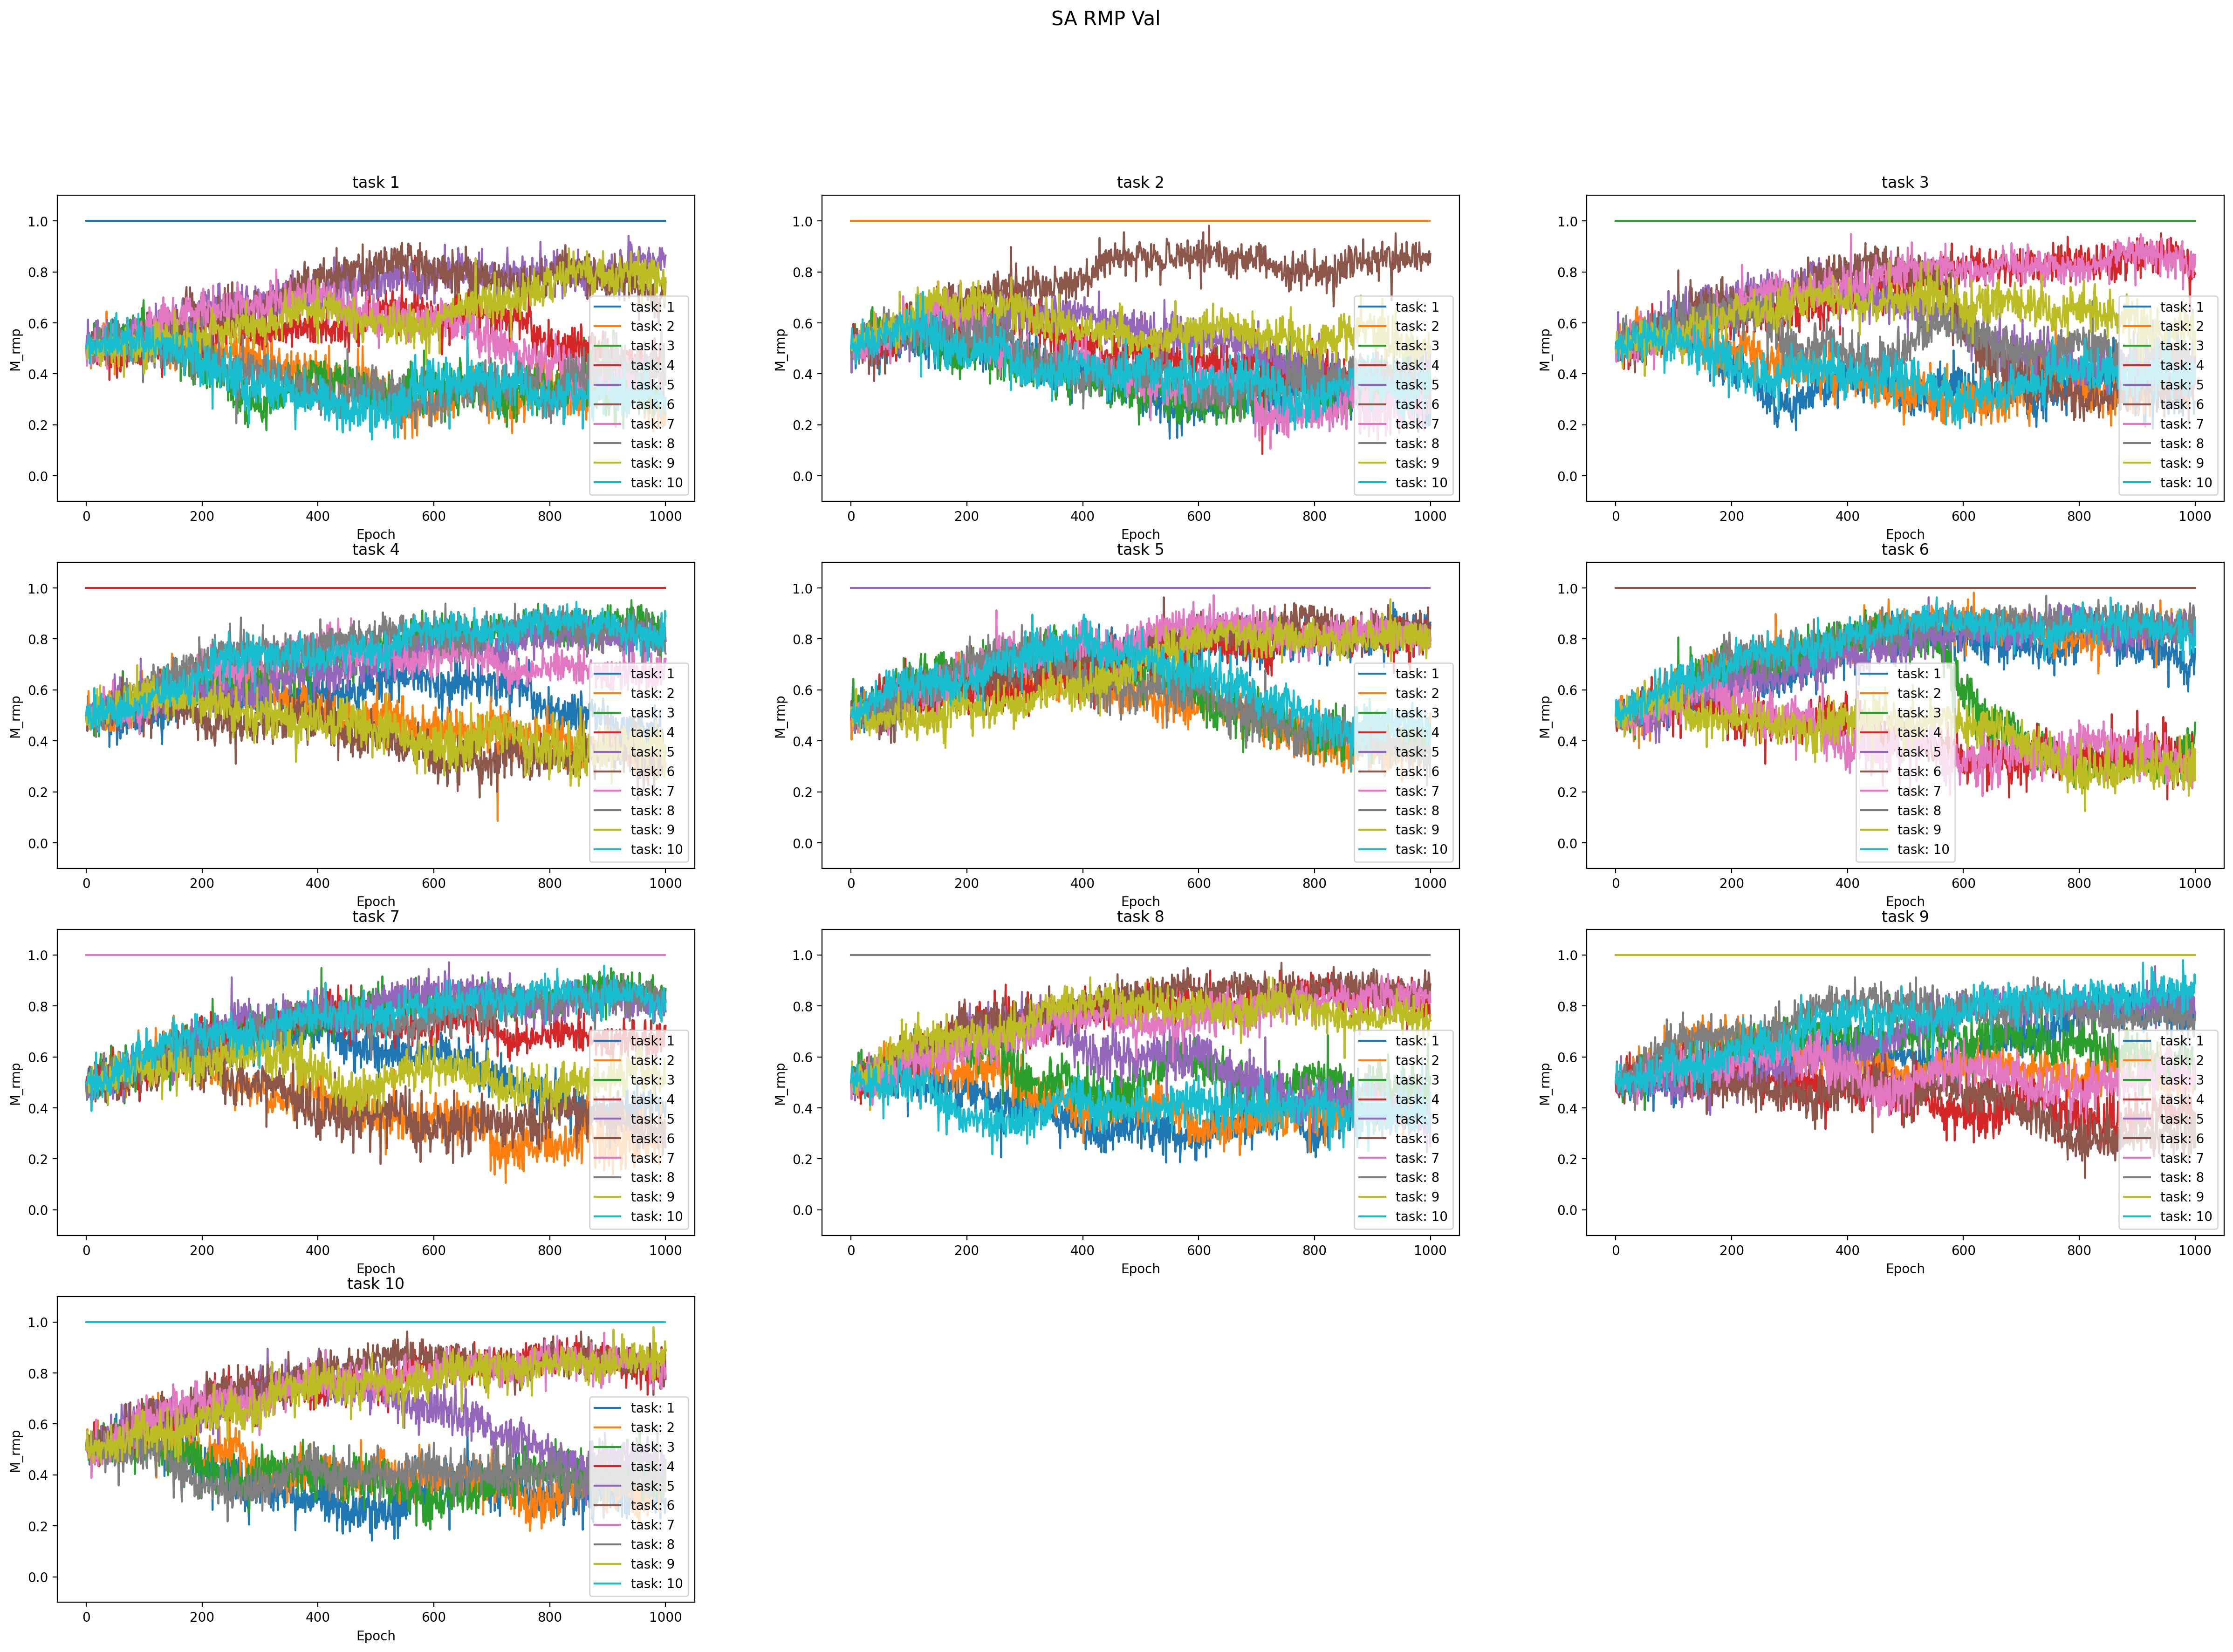

In [32]:
fig = plt.figure(figsize = (30, 20), dpi= 200)
fig.suptitle("SA RMP Val\n", size = 15)
fig.set_facecolor("white")

for i in range (len(tasks)):
    for j in range (len(tasks)):
        r, c = min(i, j), max(i, j)
        if i != j: 
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(len(sa_rmp_his[r][c])), np.array(sa_rmp_his[r][c])[:, 0], label= 'task: ' +str(j + 1))
            plt.legend()
        else:
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
            plt.legend()




    plt.title('task ' + str( i + 1))
    plt.xlabel("Epoch")
    plt.ylabel("M_rmp")
    plt.ylim(bottom = -0.1, top = 1.1)


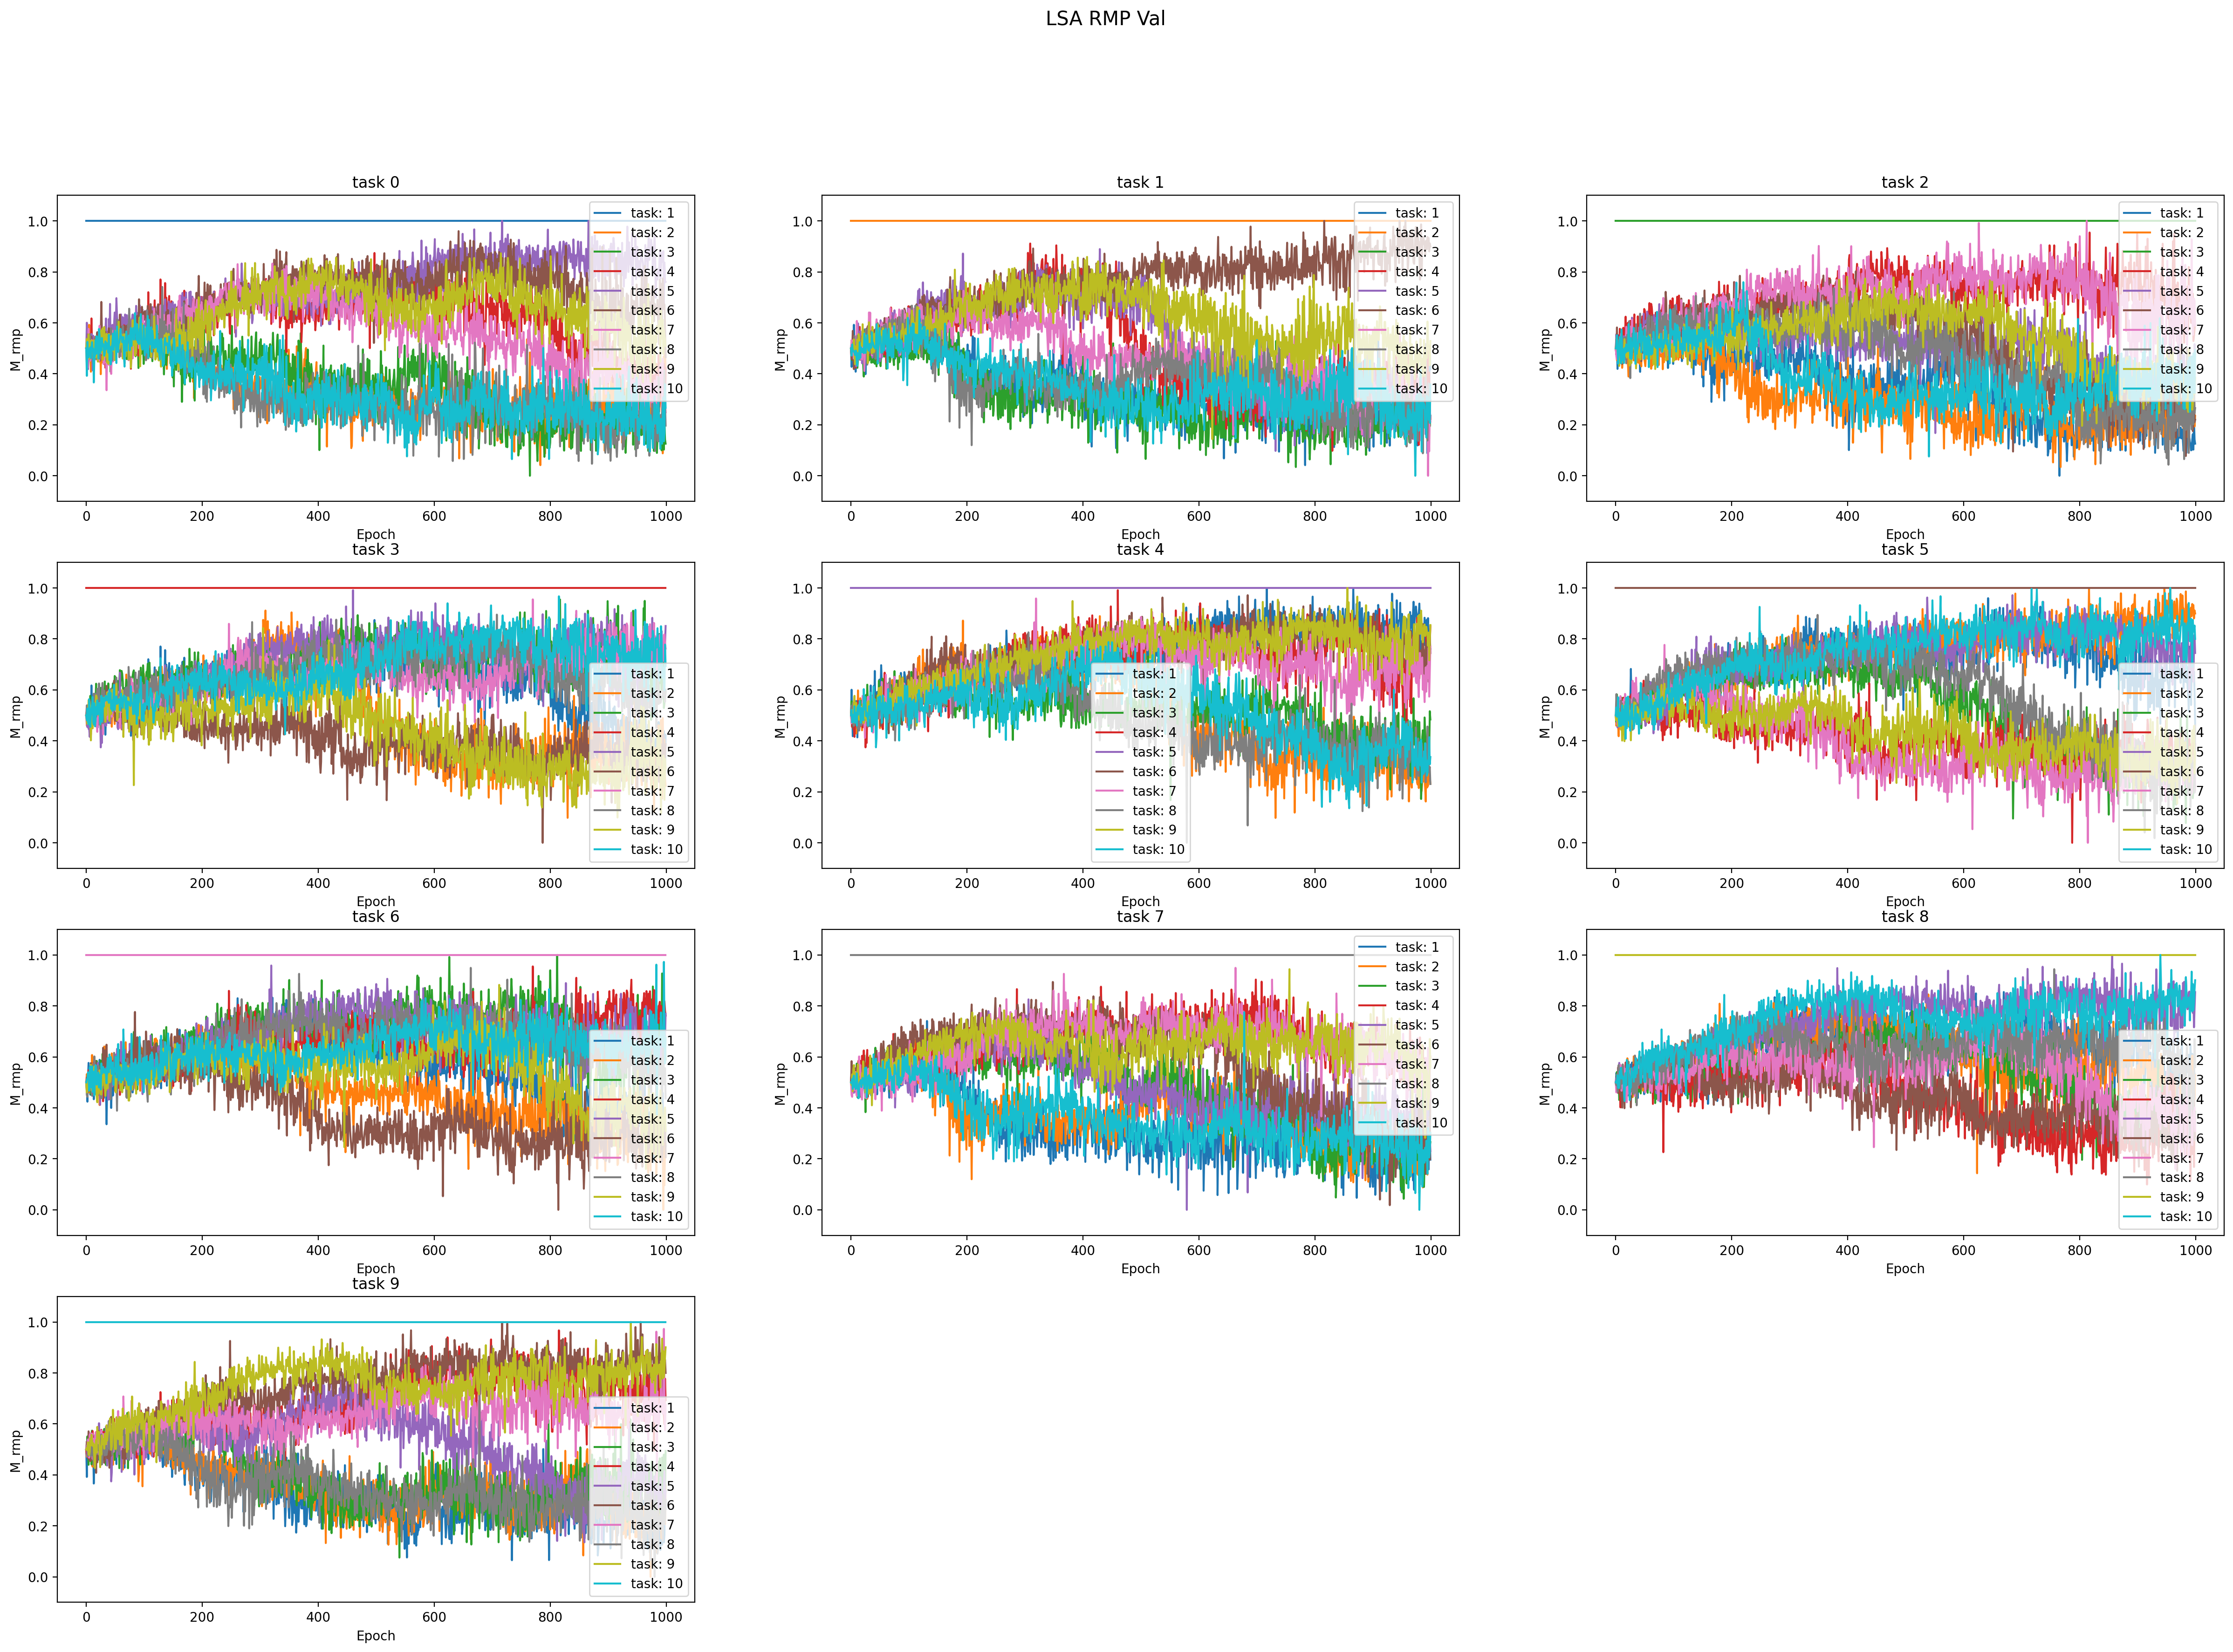

In [33]:
fig = plt.figure(figsize = (30, 20), dpi= 200)
fig.suptitle("LSA RMP Val\n", size = 15)
fig.set_facecolor("white")

for i in range (len(tasks)):
    for j in range (len(tasks)):
        r, c = min(i, j), max(i, j)
        if i != j: 
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(1000), np.array(lsa_rmp_his[r][c])[:1000, 0], label= 'task: ' +str(j + 1))
            plt.legend()
        else:
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
            plt.legend()



    plt.title('task ' + str( i))
    plt.xlabel("Epoch")
    plt.ylabel("M_rmp")
    plt.ylim(bottom = -0.1, top = 1.1)
